#### Install Libraries

In [1]:
! pip install livelossplot --quiet

### Import libraries

In [2]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow.keras as keras

import sys
sys.path.append('/home/jovyan/work')

import nima as nima


In [23]:
! pwd

/home/jovyan


In [59]:
AVA_DATASET_DIR = '/home/jovyan/work/data/AVA/'
PROJECT_ROOT_DIR = '/home/jovyan/work/'
AVA_IMAGES_DIR = os.path.join(AVA_DATASET_DIR, 'images')
WEIGHTS_DIR = os.path.join(PROJECT_ROOT_DIR, )
assert os.path.isdir(AVA_DATASET_DIR), f'Invalid directory : {AVA_DATASET_DIR}'

from nima.utils.ava_dataset_utils import load_data, get_rating_columns

### Load Dataset

In [60]:
print(f'Project Root Directory : {PROJECT_ROOT_DIR}')

df_train, df_valid, df_test = load_data(AVA_DATASET_DIR, sample_size=10000)
print(f"Training length : {len(df_train)}, Validation length : {len(df_valid)}, Test size : {len(df_test)}")

Project Root Directory : /home/jovyan/work/
Number of samples picked 10000
Training length : 6649, Validation length : 2850, Test size : 500


### Create Model

In [70]:
from nima.model.model_builder import NIMA

nima_cnn = NIMA(base_model_name='vgg', metrics=['accuracy'])
nima_cnn.build()
nima_cnn.model.summary()
nima_cnn.compile()

Model's module - tensorflow.keras.applications.vgg19.VGG19
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________


### Create Datagenerators

In [71]:
from nima.model.data_generator import NimaDataGenerator

x_col, y_cols = 'image_id', get_rating_columns()

train_datagen = NimaDataGenerator(
    df_train,
    AVA_IMAGES_DIR,
    x_col,
    y_cols,
    nima_cnn.preprocessing_function(),
    is_train=True,
    batch_size=32,
)
valid_datagen = NimaDataGenerator(
    df_valid,
    AVA_IMAGES_DIR,
    x_col,
    y_cols,
    nima_cnn.preprocessing_function(),
    is_train=True,
    batch_size=32,
)
test_datagen = NimaDataGenerator(
    df_test,
    AVA_IMAGES_DIR,
    x_col,
    None,
    nima_cnn.preprocessing_function(),
    is_train=False,
    batch_size=32,
)

Found 6649 valid image filenames belonging to 10 classes.
Found 2850 valid image filenames belonging to 10 classes.
Found 500 valid image filenames belonging to 10 classes.


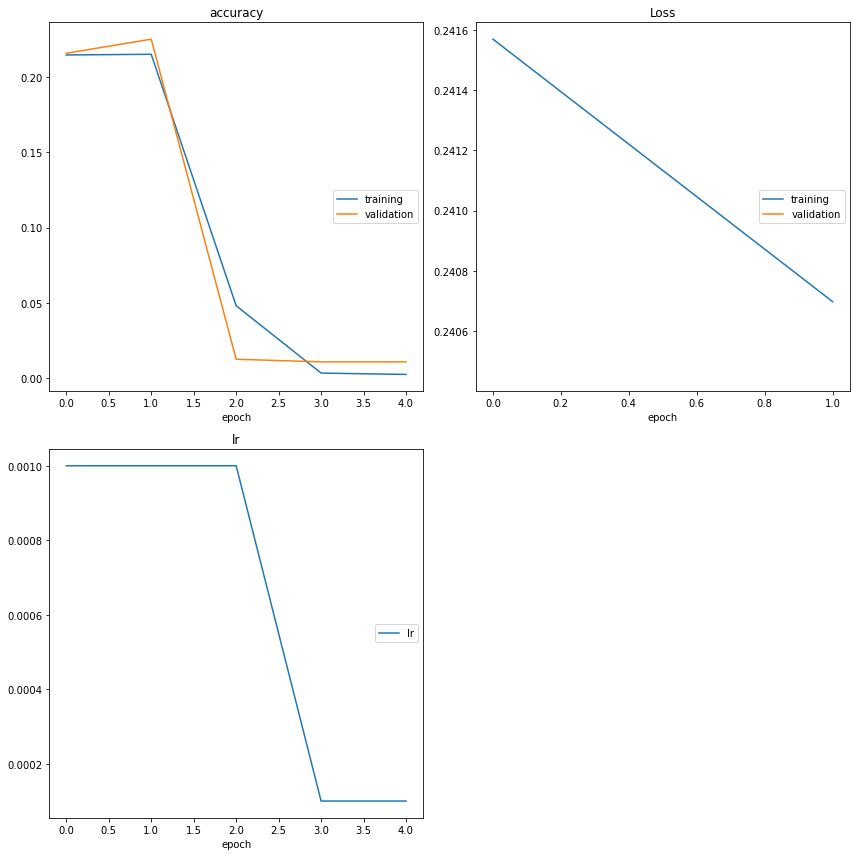

accuracy
	training         	 (min:    0.002, max:    0.215, cur:    0.002)
	validation       	 (min:    0.011, max:    0.225, cur:    0.011)
Loss
	training         	 (min:    0.241, max:    0.242, cur:      nan)
	validation       	 (min:    0.240, max:    0.240, cur:      nan)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)
Epoch 00005: early stopping
Time taken : 05:37:10


In [72]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from livelossplot.inputs.keras import PlotLossesCallback
import time
    
arg_verbose, arg_epochs = 1, 32

# # set model weight and path
# weight_filename = f'{nima_cnn.base_model_name}_weight_best.hdf5'
# weight_filepath = os.path.join(WEIGHTS_DIR, weight_filename)
# print(f'Model Weight path : {weight_filepath}')

# es = EarlyStopping(monitor='val_loss', patience=4, verbose=arg_verbose)
# ckpt = ModelCheckpoint(
#     filepath=weight_filepath,
#     save_weights_only=True,
#     monitor="val_earth_movers_distance",
#     mode="auto",
#     save_best_only=True,
# )
# lr = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1)
# plot_loss = PlotLossesCallback()

# # start training
# start_time = time.perf_counter()
# history = nima_cnn.model.fit(train_datagen, validation_data=valid_datagen,
#     epochs=arg_epochs, callbacks=[es, ckpt, lr, plot_loss],
#     verbose=arg_verbose)
# end_time = time.perf_counter()
# print(f'Time taken : {time.strftime("%H:%M:%S", time.gmtime(end_time-start_time))}')

# result_df = pd.DataFrame(history.history)

result_df, weight_filepath = nima_cnn.train_model(train_datagen, valid_datagen, epochs=arg_epochs, verbose=arg_verbose)

In [74]:
result_df.head()

,loss,accuracy,val_loss,val_accuracy,lr
0,0.241569,0.214844,0.240456,0.215972,0.0010
1,0.240698,0.215294,NaN,0.225347,0.0010
2,NaN,0.048077,NaN,0.012500,0.0010
3,NaN,0.003305,NaN,0.010764,0.0001
4,NaN,0.002404,NaN,0.010764,0.0001


In [ ]:
test_datagen = NimaDataGenerator(df_test, )
nima_cnn.model.predict